# Setup

In [2]:
# Used to read .env files, for access tokens and other secrets or configurations
%load_ext dotenv
%dotenv
import os

In [3]:
from github import Github
import pandas
from matplotlib import pyplot
import numpy
import seaborn

from datetime import datetime, timedelta

In [4]:
seaborn.set_theme()
seaborn.set_style('whitegrid')

In [5]:
# The github token is stored in a .env file next to this notebook in the form "GITHUB_TOKEN = <your token here>"
github = Github(os.getenv("GITHUB_TOKEN"))

# Team Constants

These are things that describe how the team work and are static

## Sprint Management

In [6]:
# In the following, we will assume that sprints are totally regular, starting with a fixed date.
# The helper functions can of course be adapted to represent, e.g., changes in sprint duration or holiday breaks

start_date_first_sprint = datetime(2020, 4, 27) # It's a monday, development actually started 02.05.2020
sprint_length = timedelta(weeks=2)

def date_to_sprint(date_to_convert):
    return max(0, (date_to_convert - start_date_first_sprint) // sprint_length + 1) # Sprint "0" is everything before the first

def sprint_to_start_date(sprint_to_convert):
    return start_date_first_sprint + (sprint_to_convert - 1) * sprint_length

## Repositories

In [7]:
bpmn_js_repo = github.get_repo('bpmn-io/bpmn-js')

# Analysis: Issue Arrival

## Data Collection and Preprocessing

In [8]:
repo = bpmn_js_repo

In [9]:
issues_raw = repo.get_issues(state='all')
issues_dataframe = pandas.DataFrame(issues_raw, columns=['issue'])
issues_dataframe

,issue
0,"Issue(title=""chore: update dependency mkdirp t..."
1,"Issue(title=""chore: update dependency execa to..."
2,"Issue(title=""chore: update dependency del to v..."
3,"Issue(title=""chore: update dependency babel-lo..."
4,"Issue(title=""deps: update dependency diagram-j..."
...,...
1749,"Issue(title=""1st Release"", number=5)"
1750,"Issue(title=""I can create a new process"", numb..."
1751,"Issue(title=""I can open a simple BPMN 2.0 proc..."
1752,"Issue(title=""I can drag and drop BPMN elements..."


In [10]:
issues_opened_per_sprint = issues_dataframe.groupby(by=(lambda index: date_to_sprint(issues_dataframe.loc[index].issue.created_at)))
issues_opened_per_sprint

In [11]:
closed_issues = issues_dataframe[issues_dataframe.apply(lambda x: x.issue.closed_at is not None, axis=1)]
issues_closed_per_sprint = closed_issues.groupby(by=(lambda index: date_to_sprint(issues_dataframe.loc[index].issue.closed_at)))
issues_closed_per_sprint

In [12]:
issues = pandas.DataFrame(index=range(0, date_to_sprint(datetime.today())+1)) # The range ensures that there are rows for sprints where no issues were opened or closed
issues.index.name = 'sprint'
issues['opened'] = issues_opened_per_sprint.count().astype('Int64')
issues['closed'] = issues_closed_per_sprint.count().astype('Int64')
issues = issues.fillna(0) # Replace NaN values from outer join with zero
issues['open_at_start'] = (issues.opened - issues.closed).cumsum().shift(fill_value=0) # Issues open at start of each sprint = sum of issues opened - closed beforea
issues

,opened,closed,open_at_start
sprint,,,
0,1315,1248,0
1,8,6,67
2,2,3,69
3,4,7,68
4,0,0,65
...,...,...,...
63,3,6,95
64,8,9,92
65,6,5,91


## Analyze

In [82]:
start_sprint = date_to_sprint(datetime(2022, 1, 1)) # Using date here to be able to explore sprint length
end_sprint = date_to_sprint(datetime(2022, 10, 1))

In [83]:
issues_focus = issues[(issues.index >= start_sprint) & (issues.index <= end_sprint)]
issues_focus

,opened,closed,open_at_start
sprint,,,
44,1,0,92
45,20,22,93
46,14,13,91
47,9,17,92
48,12,13,84
49,6,7,83
50,8,7,82
51,8,2,83
52,7,4,89


### Activity

<AxesSubplot:xlabel='sprint', ylabel='no. issues'>

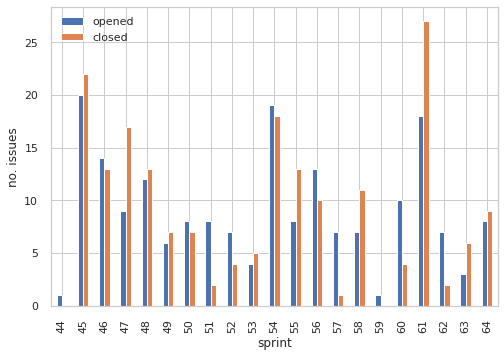

In [84]:
issues_focus.plot.bar(y=['opened', 'closed'], ylabel='no. issues')

### Summed Activity

<AxesSubplot:xlabel='sprint', ylabel='no. issues'>

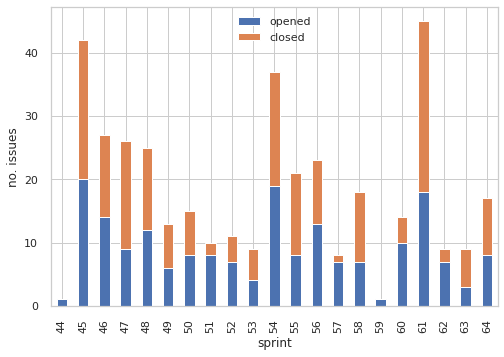

In [86]:
issues_focus.plot.bar(stacked=True, y=['opened', 'closed'], ylabel='no. issues')

Hm ... sprint 59 seems abnormal ... when was that?

In [88]:
sprint_to_start_date(59)

datetime.datetime(2022, 7, 18, 0, 0)

### Backlog Size

<AxesSubplot:xlabel='sprint'>

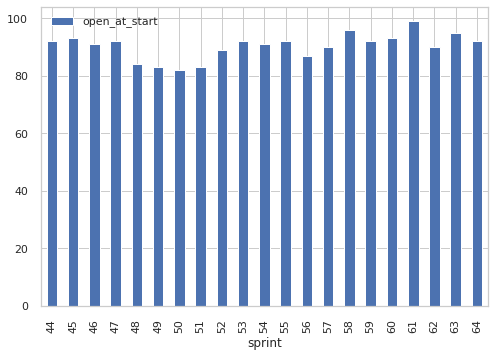

In [108]:
issues_focus.plot.bar(y=['open_at_start'])

<AxesSubplot:xlabel='sprint'>

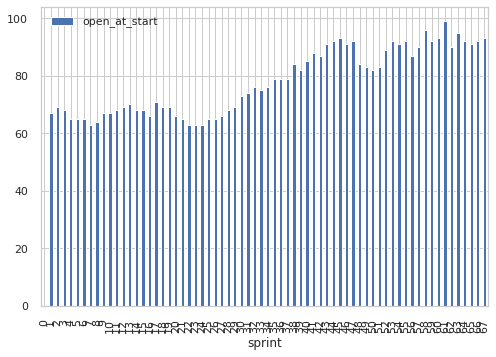

In [96]:
issues.plot.bar(y=['open_at_start'])

# Analysis: Health Monitor

### Current Backlog Size

In [109]:
backlog = pandas.DataFrame(repo.get_issues(state='open'), columns=['issue'])
backlog.size

92

In [142]:
def issue_type(issue):
    labels = list(issue.get_labels())
    if any(label.name == 'enhancement' for label in labels):
        return 'feature'
    if any(label.name == 'bug' for label in labels):
        return 'bug'
    return 'other'

In [143]:
backlog['type'] = backlog.issue.apply(issue_type)

In [148]:
backlog['opened'] = backlog.issue.apply(lambda issue: issue.created_at)

In [160]:
backlog['time_open'] = (backlog.opened - datetime.today()) * -1

In [165]:
backlog

,issue,type,opened,time_open
0,"Issue(title=""Issue in the getBusinessObject im...",other,2022-11-07 11:52:47,0 days 05:20:35.697576
1,"Issue(title=""chore: update dependency babel-lo...",other,2022-10-31 00:08:14,7 days 17:05:08.697576
2,"Issue(title=""loopCharacteristics does not set ...",bug,2022-10-19 12:04:19,19 days 05:09:03.697576
3,"Issue(title=""Drop to append"", number=1749)",feature,2022-10-10 19:04:58,27 days 22:08:24.697576
4,"Issue(title=""Boundary event can be placed on p...",bug,2022-08-29 09:30:35,70 days 07:42:47.697576
...,...,...,...,...
87,"Issue(title=""I can model a message element of ...",feature,2016-01-13 09:15:52,2490 days 07:57:30.697576
88,"Issue(title=""Provide documentation"", number=332)",other,2015-08-12 08:56:39,2644 days 08:16:43.697576
89,"Issue(title=""Add key strokes to palette toolti...",other,2015-07-15 08:57:33,2672 days 08:15:49.697576
90,"Issue(title=""Add mouse move styling to lasso t...",feature,2015-01-22 07:51:03,2846 days 09:22:19.697576


In [176]:
backlog[backlog.apply(lambda row: row.time_open < timedelta(days=1000), axis=1)].time_open.mean()

Timedelta('411 days 16:12:30.588485084')

In [195]:
backlog.opened.dt

<AxesSubplot:xlabel='opened'>

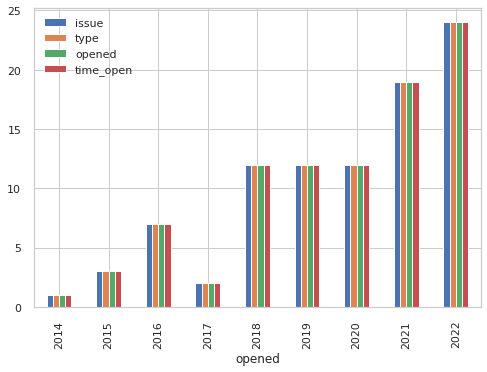

In [196]:
backlog.groupby(backlog.opened.dt.year).count().plot.bar()

In [192]:
backlog.hist(column='created', bins=10)

KeyError: "None of [Index(['created'], dtype='object')] are in the [columns]"

In [162]:
backlog.time_open.mean()

Timedelta('962 days 07:09:21.599749920')

In [147]:
backlog.groupby(by='type').count()

,issue
type,
bug,39
feature,36
other,17


# Test Coverage

# Commit Heatmap 

In [19]:
sprint_to_inspect = date_to_sprint(datetime.today())-1
start_of_sprint = sprint_to_start_date(sprint_to_inspect-20)
end_of_sprint = sprint_to_start_date(sprint_to_inspect+1)
(start_of_sprint, end_of_sprint)

(datetime.datetime(2022, 1, 17, 0, 0), datetime.datetime(2022, 11, 7, 0, 0))

In [21]:
commits_raw = repo.get_commits(path='', since=start_of_sprint, until=end_of_sprint)
commits_dataframe = pandas.DataFrame(commits_raw, columns=['commit'])
commits_dataframe

,commit
0,"Commit(sha=""d676f4e962c8058fa5f04fd6aeb12317b9..."
1,"Commit(sha=""521ceee13e4d6e6b6a47e9e613a3b12434..."
2,"Commit(sha=""4e77940a2672b974efb212b4ace23914a7..."
3,"Commit(sha=""850a3634ac61c301ee901763babc4bffac..."
4,"Commit(sha=""57bfc2fcef4232387ac3c4ab6b6fe32a0a..."
...,...
244,"Commit(sha=""34e3fa33fd60773e521d9b8ed304de7275..."
245,"Commit(sha=""2ae21c3c57b72f3bd3dc5f0c2a8275ff52..."
246,"Commit(sha=""4e161427b8d77995749d3e2f36966247bf..."
247,"Commit(sha=""9366700235b71df25511d1a662ca1f5d14..."


In [31]:
commits_dataframe['date'] = commits_dataframe.commit.apply(lambda row: row.commit.committer.date)
commits_dataframe

,commit,date
0,"Commit(sha=""d676f4e962c8058fa5f04fd6aeb12317b9...",2022-11-02 08:59:40
1,"Commit(sha=""521ceee13e4d6e6b6a47e9e613a3b12434...",2022-11-02 08:59:40
2,"Commit(sha=""4e77940a2672b974efb212b4ace23914a7...",2022-11-02 08:59:40
3,"Commit(sha=""850a3634ac61c301ee901763babc4bffac...",2022-11-02 08:59:40
4,"Commit(sha=""57bfc2fcef4232387ac3c4ab6b6fe32a0a...",2022-11-02 08:59:40
...,...,...
244,"Commit(sha=""34e3fa33fd60773e521d9b8ed304de7275...",2022-01-20 07:48:29
245,"Commit(sha=""2ae21c3c57b72f3bd3dc5f0c2a8275ff52...",2022-01-19 08:20:34
246,"Commit(sha=""4e161427b8d77995749d3e2f36966247bf...",2022-01-19 08:20:14
247,"Commit(sha=""9366700235b71df25511d1a662ca1f5d14...",2022-01-19 08:20:14


In [44]:
commits_dataframe['day'] = commits_dataframe.date.apply(lambda row: row.day_name()[0:3])
commits_dataframe['hour'] = commits_dataframe.date.apply(lambda row: row.hour)
commits_dataframe

,commit,date,day,hour
0,"Commit(sha=""d676f4e962c8058fa5f04fd6aeb12317b9...",2022-11-02 08:59:40,Wed,8
1,"Commit(sha=""521ceee13e4d6e6b6a47e9e613a3b12434...",2022-11-02 08:59:40,Wed,8
2,"Commit(sha=""4e77940a2672b974efb212b4ace23914a7...",2022-11-02 08:59:40,Wed,8
3,"Commit(sha=""850a3634ac61c301ee901763babc4bffac...",2022-11-02 08:59:40,Wed,8
4,"Commit(sha=""57bfc2fcef4232387ac3c4ab6b6fe32a0a...",2022-11-02 08:59:40,Wed,8
...,...,...,...,...
244,"Commit(sha=""34e3fa33fd60773e521d9b8ed304de7275...",2022-01-20 07:48:29,Thu,7
245,"Commit(sha=""2ae21c3c57b72f3bd3dc5f0c2a8275ff52...",2022-01-19 08:20:34,Wed,8
246,"Commit(sha=""4e161427b8d77995749d3e2f36966247bf...",2022-01-19 08:20:14,Wed,8
247,"Commit(sha=""9366700235b71df25511d1a662ca1f5d14...",2022-01-19 08:20:14,Wed,8


In [46]:
commits_dataframe.hour.value_counts().sort_index()

6      4
7     37
8     30
9     22
10    36
11    26
12     7
13    27
14    16
15    12
16     9
18     2
19     8
20     6
21     4
22     3
Name: hour, dtype: int64